# NIPS Author Cluster Analysis:

## Abstract:
本報告為2018年下學期統計計算與模擬之期末報告，欲使用集群分析對高維度資料進行分群，並檢驗其效果。使用資料為NIPS(Conference and Workshop on Neural Information Processing Systems)從1987年到2017年的所有論文，資料包含論文id、作者id、以及論文全文，資料來源為kaggle(https://www.kaggle.com/benhamner/nips-papers) 。

透過文字分析技術，我們從文本中萃取出詞頻、詞性等特徵(feature)，接著篩選出論文數前10多的作者與其文章並進行標注。透過集群分析，試著將資料分群並檢驗其正確率(purity)，最後結果約為0.3至0.4。


***
## 1. Loading data and modules:

In [609]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk
import re
import scipy
import itertools
import sklearn
from nltk import word_tokenize
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from collections import Counter
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
%matplotlib inline
plt.style.use('ggplot')

#### 常數:
N : 欲分析之作者數(與分群數) <br>
SVD_N : SVD降維數 

In [574]:
N = 10
SVD_N = 100

In [150]:
papers = pd.read_csv("nips-papers/papers.csv")
authors = pd.read_csv('nips-papers/paper_authors.csv')

載入斷詞用的 porter stemmer與停用詞列表 :

In [599]:
ps = PorterStemmer()
stop = set(stopwords.words('english'))

---
## 2. Find top N author clustering:


In [568]:
#論文數最多的前N名作者
N = 10
top = sorted(Counter(authors.author_id).items(),key=lambda x:x[1],reverse=True)[0:N]
topauthor = [s[0] for s in top]
#找出這些作者對應的論文
paper_id = []
#for i in range(authors.shape[0]):
for author_id in topauthor:
    paper_id.append(list(authors.paper_id[authors.author_id==author_id].values))
paper_id = np.array(list(itertools.chain(*paper_id)))

#同篇作者可能會重複(例如，這N人中其中兩三人共寫某篇論文)，將這些論文它刪掉，使得每篇論文一定只屬於這N個作者中其中一人
## find papers that didnt have overlapped author
pid = set()
dup = set()
for i in paper_id:
    if i not in pid:
        pid.add(i)
    elif i in pid:
        dup.add(i)

#sel 為欲選取之篇章ID
sel = np.array(list(pid - dup))

#author_paper: 
author_paper = dict()
for author_id in topauthor:
    author_paper[author_id] = (list(authors.paper_id[authors.author_id==author_id].values))

#作者:文章 對應的字典，文章不重複
author_sel = dict()
for author,paperss in author_paper.items():
    temp = []
    for paper in paperss:
        if sel[np.where(sel==paper)]:
            temp.append(paper)
    author_sel[author] = temp

#ID 與 sparse matrix Row 的對照表:
#rowid 是原始sparse matrix的row對應的paper
temp = dict()
for i in range(papers.shape[0]):
    temp[papers.id[i]] = {"title":papers.title[i],"id":papers.id[i]}
temp = pd.DataFrame.from_dict(temp).transpose()
row_id = temp.index.values

#index : paper_id 對應到的 word_count sparse matrix 的row位置
index = [ np.where(row_id==i)[0][0] for i in sel]

# create author_series(paperid as index)
author_series = pd.Series(np.zeros(len(sel)))
author_series.index = sel
for a,ps in author_sel.items():
    for p in ps:
        try:
            author_series[p] = a
        except:
            print("fail at index: ",p)
len(index)            

460

***

## 3. Create Word Count table:
#### token,clean, and Stem
進行斷詞，清理，字尾處理，最後建立字數表與TF-IDF表

In [156]:
#This will take you about one hour to run
words_dict = {}
reg = re.compile("^[^\w\s|-|_]|[^\w\s\|-|_]$|[0-9]|^[a-z]$|^_")
#for i in range(10):
for i in range(papers.shape[0]):
    #stem and tokenize
    token_stem = [ps.stem(word) for word in word_tokenize(papers.paper_text[i].lower()) if word not in stop]
    #clean
    token_stem = [word for word in token_stem if not reg.search(word)]
    words_dict[(papers.id[i])] = dict(Counter(token_stem))

word_count_df = pd.DataFrame.from_dict(words_dict).transpose()
word_count_df =word_count_df.fillna(0)
rownames = word_count_df.index
# in case you blow up your fucking ram
del words_dict
del papers

# convert to sparse matrix
word_count_sparse = scipy.sparse.csr_matrix(word_count_df.values)

# TF-IDF
transformer = TfidfTransformer()
vsm_tfidf = transformer.fit_transform(word_count_df)

# save sparse matrix (again, in case you blow up your fucking ram)
scipy.sparse.save_npz('/vsm_tfidf.npz', vsm_tfidf)
scipy.sparse.save_npz('/tmp/word_count_sparse.npz', word_count_sparse)

***
## 4. Subset and SVD Decomposition:

In [114]:
vsm_subset = vsm_tfidf.toarray()[index,]
svd = TruncatedSVD(SVD_N)
vsm_subset_svd = svd.fit_transform(vsm_subset)

#降維後建立df
vsm_subset_svd_df = pd.DataFrame(vsm_subset_svd)
vsm_subset_svd_df.index = sel
vsm_subset_svd_df.index.name = "paper ID"

***
## 5. First try with Kmeans

In [582]:
kmeans = KMeans(N).fit(vsm_subset_svd_df)

#result DF:
res = author_series.to_frame(name="AuthorID")
res["cluster"] = kmeans.labels_

#result table:
res_cluster = res.groupby(['cluster',"AuthorID"]).size()
acc =[]

for i in set(res_cluster.index.get_level_values('cluster')):
    temp = res_cluster[i].sort_values(ascending=False)
    acc.append([i,temp.iloc[0:1].index[0],temp.iloc[0],
                temp.sum(),temp.iloc[0]/temp.sum()])
print("Accuracy : {}".format(sum(np.array(acc)[:,2])/len(res)),end="\n\n") 
print("Accuracy in each cluster:")
pd.DataFrame(acc,columns=["Cluster","Author","count","total","accuracy"])

Accuracy : 0.3717391304347826

Accuracy in each cluster:


,Cluster,Author,count,total,accuracy
0,0,54.0,5,8,0.625000
1,1,121.0,32,88,0.363636
2,2,632.0,18,59,0.305085
3,3,178.0,16,23,0.695652
4,4,632.0,7,15,0.466667
5,5,3001.0,6,12,0.500000
6,6,1020.0,36,129,0.279070
7,7,1472.0,30,92,0.326087
8,8,632.0,13,25,0.520000
9,9,54.0,8,9,0.888889


/Users/hyades/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: The set_color_cycle attribute was deprecated in version 1.5. Use set_prop_cycle instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


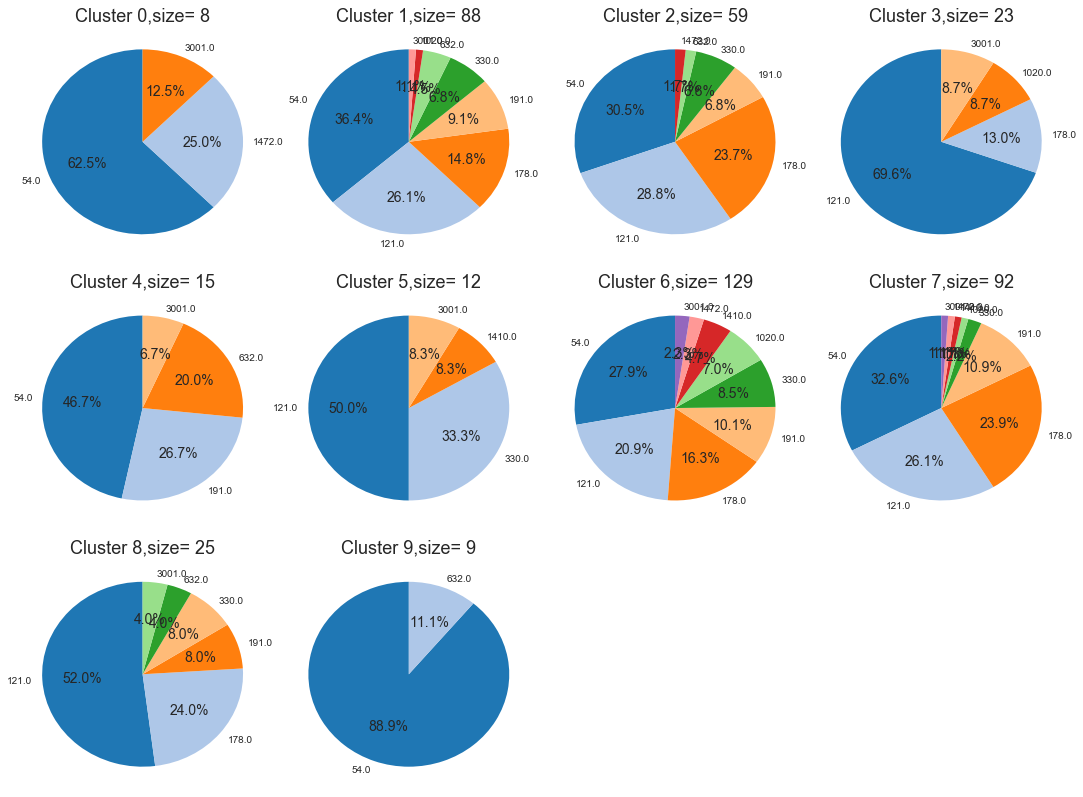

In [585]:
plt.style.use('seaborn')
plt.rcParams['font.size'] = 14
cm = plt.get_cmap('tab20')
temp = res.groupby(['cluster',"AuthorID"]).size()
fig = plt.figure(figsize=(15,15))
for i in range(kmeans.n_clusters):
    ax = fig.add_subplot(4,4,i+1)
    ax.set_color_cycle([cm(1.0*i/20) for i in range(20)])
    ax.pie(temp[i].sort_values(ascending=False),labels=temp[i].index,
           autopct='%1.1f%%',startangle=90)    
    ax.set_title("Cluster {},size= {}".format(i,temp[i].sum()),fontsize=18)
plt.tight_layout()

***
## 6. Add other features:

加入其他特徵改善分群結果:

##### 平均句長(取字數大於10) : sent_meanlen
##### 句數: sent_count   
##### 字數大於100的句數 : sent100 
##### 詞性向量 : pos 找幾個特徵來玩看看


In [231]:
sent_dict = dict()
for i in sel:
    try:
        sent_dict[i] = [len(word) for word in papers.loc[papers.id==i,"paper_text"].values[0].split("\n") if len(word)>10]
    except:
        print("fail at :",i)
        
sent100_dict = dict()
for i in sel:
    try:
        sent_count = [len(word) for word in papers.loc[papers.id==i,"paper_text"].values[0].split("\n") if len(word)>100]
        sent100_dict[i] = len(sent_count)
    except:
        print("fail at :",i)

# convert to series:
sent_count = pd.Series({key:len(value) for key,value in sent_dict.items()},name="Sent_count")
sent_meanlen = pd.Series({key:np.mean(value) for key,value in sent_dict.items()},name="Sent_meanlen")
sent100 = pd.Series(sent100_dict,name="sent_over100_count")        

### POS table:

In [476]:
pos_sel = ['CC','DT','EX','IN','MD','WP','WRB','WDT']
pap_pos_dict = dict()
for i in sel:
    pos_dict = dict()
    pap = papers.loc[papers.id==i,"paper_text"].values[0]
    pap = word_tokenize(pap)
    pap = nltk.pos_tag(pap)
    n = sent_count[i]
    for p in pos_sel:
        # find how many word in this pos tag:
        pos_dict[p] = len([word for word,pos in pap if pos==p])/n
    pap_pos_dict[i] = pos_dict
pos = pd.DataFrame.from_dict(pap_pos_dict).transpose()    

## Feature DF

#### Normalize:
將變數標準化，但加上較重的權重:

In [645]:
WEIGHT=[3]*3
#WEIGHT = 2
feature = pd.concat([sent_count,sent_meanlen,sent100],axis=1)
feature = feature.loc[sel,:]
feature = pd.DataFrame(sklearn.preprocessing.normalize(feature),columns=feature.columns,index=feature.index)*WEIGHT
feature = pd.concat([feature,vsm_subset_svd_df],axis=1)

WEIGHT2 = [3]*3+[1]*8
feature_pos = pd.concat([sent_count,sent_meanlen,sent100,pos],axis=1)
feature_pos = feature_pos.loc[sel,:]
feature_pos = pd.DataFrame(sklearn.preprocessing.normalize(feature_pos),columns=feature_pos.columns,index=feature_pos.index)*WEIGHT2
feature_pos = pd.concat([feature_pos,vsm_subset_svd_df],axis=1)


#### Visualization of features : 

/Users/hyades/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: The set_color_cycle attribute was deprecated in version 1.5. Use set_prop_cycle instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


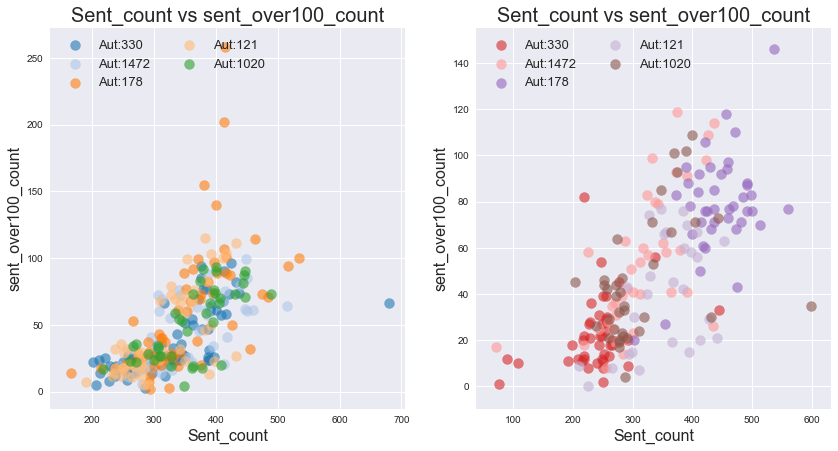

In [402]:
#set color cycle:
def plotscatter(x,y):
    cm = plt.get_cmap('tab20')
    fig = plt.figure(figsize=(14,7))
    ax = fig.add_subplot(121)
    ax.set_color_cycle([cm(1.0*i/20) for i in range(20)])
    for key,value in list(author_sel.items())[0:5]:
        ax.scatter(x=feature.loc[value,x],
                   y=feature.loc[value,y],
                   s=100,alpha=0.6)
    ax.legend(["Aut:{}".format(key) for key in author_sel.keys()],loc="upper left",fontsize=13,ncol=2,shadow=True)
    ax.set_title("{} vs {}".format(x,y),fontsize=20)
    ax.set_xlabel(x,fontsize=16)
    ax.set_ylabel(y,fontsize=16)

    ax = fig.add_subplot(122)
    ax.set_color_cycle([cm(1.0*i/20+0.3) for i in range(20)])
    for key,value in list(author_sel.items())[5:10]:
        ax.scatter(x=feature.loc[value,x],
                   y=feature.loc[value,y],
                   s=100,alpha=0.6)
    ax.legend(["Aut:{}".format(key) for key in author_sel.keys()],loc="upper left",fontsize=13,ncol=2,shadow=True)
    ax.set_title("{} vs {}".format(x,y),fontsize=20)
    ax.set_xlabel(x,fontsize=16)
    ax.set_ylabel(y,fontsize=16)
plotscatter("Sent_count","sent_over100_count")    

***
## 7. Kmeans with other features:

In [598]:
kmeans = KMeans(N,n_init=10).fit(feature)
#result df
res = author_series.to_frame(name="AuthorID")
res["cluster"] = kmeans.labels_
#result by cluster:
res_cluster = res.groupby(['cluster',"AuthorID"]).size()
acc =[]
for i in set(res_cluster.index.get_level_values('cluster')):
    temp = res_cluster[i].sort_values(ascending=False)
    acc.append([i,temp.iloc[0:1].index[0],temp.iloc[0],
                temp.sum(),temp.iloc[0]/temp.sum()])
print("Accuracy: {:3f}".format(sum(np.array(acc)[:,2])/len(res)))

Accuracy: 0.384783


/Users/hyades/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: The set_color_cycle attribute was deprecated in version 1.5. Use set_prop_cycle instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


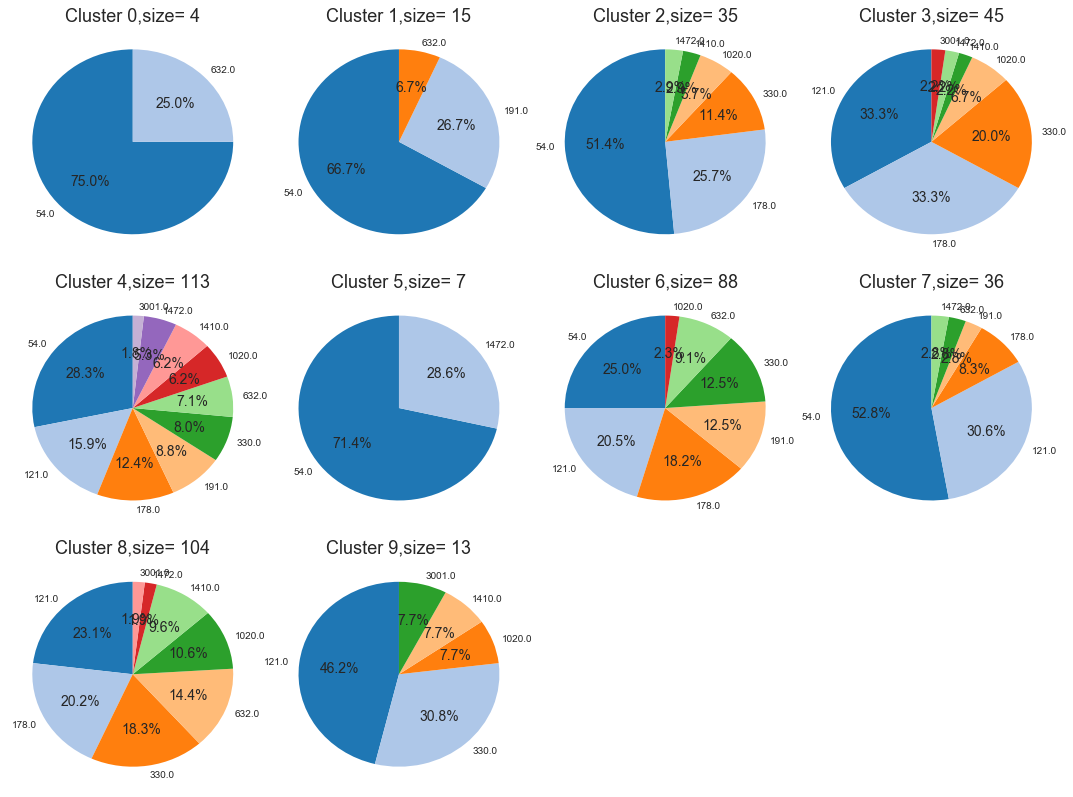

In [472]:
pd.DataFrame(acc,columns=["Cluster","Author","count","total","accuracy"])
plt.style.use('seaborn')
plt.rcParams['font.size'] = 14
temp = res.groupby(['cluster',"AuthorID"]).size()
fig = plt.figure(figsize=(15,15))
for i in range(kmeans.n_clusters):
    ax = fig.add_subplot(4,4,i+1)
    ax.set_color_cycle([cm(1.0*i/20) for i in range(20)])
    ax.pie(temp[i].sort_values(ascending=False),labels=temp[i].index,
           autopct='%1.1f%%',startangle=90)    
    ax.set_title("Cluster {},size= {}".format(i,temp[i].sum()),fontsize=18)
plt.tight_layout()

Still looks like shit.

## Does additional features really make accuracy better ?

In [652]:
feature_res = []
feature_pos_res = []
svd_res=[]
em_s_res =[]
em_f_res = []
em_fp_res = []
for j in range(1000):
    kmeans = KMeans(N,n_init=10).fit(feature)
    #result df
    res = author_series.to_frame(name="AuthorID")
    res["cluster"] = kmeans.labels_
    #result by cluster:
    res_cluster = res.groupby(['cluster',"AuthorID"]).size()
    acc =[]
    for i in set(res_cluster.index.get_level_values('cluster')):
        temp = res_cluster[i].sort_values(ascending=False)
        acc.append([i,temp.iloc[0:1].index[0],temp.iloc[0],
                    temp.sum(),temp.iloc[0]/temp.sum()])
    feature_res.append(sum(np.array(acc)[:,2])/len(res))

    kmeans = KMeans(N,n_init=10).fit(feature_pos)
    #result df
    res = author_series.to_frame(name="AuthorID")
    res["cluster"] = kmeans.labels_
    #result by cluster:
    res_cluster = res.groupby(['cluster',"AuthorID"]).size()
    acc =[]
    for i in set(res_cluster.index.get_level_values('cluster')):
        temp = res_cluster[i].sort_values(ascending=False)
        acc.append([i,temp.iloc[0:1].index[0],temp.iloc[0],
                    temp.sum(),temp.iloc[0]/temp.sum()])
    feature_pos_res.append(sum(np.array(acc)[:,2])/len(res))

    kmeans = KMeans(N,n_init=10).fit(vsm_subset_svd_df)
    res = author_series.to_frame(name="AuthorID")
    res["cluster"] = kmeans.labels_
    res_cluster = res.groupby(['cluster',"AuthorID"]).size()
    acc =[]
    for i in set(res_cluster.index.get_level_values('cluster')):
        temp = res_cluster[i].sort_values(ascending=False)
        acc.append([i,temp.iloc[0:1].index[0],temp.iloc[0],
                    temp.sum(),temp.iloc[0]/temp.sum()])
    svd_res.append(sum(np.array(acc)[:,2])/len(res))
    
    em = GaussianMixture(n_components=10,n_init=10,covariance_type="full").fit(vsm_subset_svd_df)
    res = author_series.to_frame(name="AuthorID")
    res["em"] = em.predict(vsm_subset_svd_df)
    #result by cluster:
    res_cluster = res.groupby(['em',"AuthorID"]).size()
    acc =[]
    for i in set(res_cluster.index.get_level_values('em')):
        temp = res_cluster[i].sort_values(ascending=False)
        acc.append([i,temp.iloc[0:1].index[0],temp.iloc[0],
                    temp.sum(),temp.iloc[0]/temp.sum()])
    em_s_res.append(sum(np.array(acc)[:,2])/len(res))

    em = GaussianMixture(n_components=10,n_init=10,covariance_type="full").fit(feature)
    res = author_series.to_frame(name="AuthorID")
    res["em"] = em.predict(feature)
    #result by cluster:
    res_cluster = res.groupby(['em',"AuthorID"]).size()
    acc =[]
    for i in set(res_cluster.index.get_level_values('em')):
        temp = res_cluster[i].sort_values(ascending=False)
        acc.append([i,temp.iloc[0:1].index[0],temp.iloc[0],
                    temp.sum(),temp.iloc[0]/temp.sum()])
    em_f_res.append(sum(np.array(acc)[:,2])/len(res))

    em = GaussianMixture(n_components=10,n_init=10,covariance_type="full").fit(feature_pos)
    res = author_series.to_frame(name="AuthorID")
    res["em"] = em.predict(feature_pos)
    #result by cluster:
    res_cluster = res.groupby(['em',"AuthorID"]).size()
    acc =[]
    for i in set(res_cluster.index.get_level_values('em')):
        temp = res_cluster[i].sort_values(ascending=False)
        acc.append([i,temp.iloc[0:1].index[0],temp.iloc[0],
                    temp.sum(),temp.iloc[0]/temp.sum()])
    em_fp_res.append(sum(np.array(acc)[:,2])/len(res))
    
res_compare = pd.DataFrame([svd_res,feature_res,feature_pos_res,em_s_res,em_f_res,em_fp_res],
                           index=["svd","feature","feature_pos","em_svd","em_f","em_fp"]).transpose()
res_compare 

,svd,feature,feature_pos,em_svd,em_f,em_fp
0,0.356522,0.367391,0.363043,0.369565,0.319565,0.326087
1,0.363043,0.336957,0.304348,0.371739,0.326087,0.336957
2,0.384783,0.328261,0.306522,0.369565,0.350000,0.369565
3,0.352174,0.332609,0.330435,0.343478,0.323913,0.332609
4,0.341304,0.328261,0.315217,0.413043,0.321739,0.334783
5,0.382609,0.339130,0.306522,0.365217,0.363043,0.323913
6,0.369565,0.345652,0.330435,0.389130,0.336957,0.365217
7,0.350000,0.330435,0.308696,0.352174,0.363043,0.330435
8,0.391304,0.317391,0.330435,0.326087,0.308696,0.384783
9,0.369565,0.365217,0.302174,0.376087,0.354348,0.310870


In [625]:
em = GaussianMixture(n_components=10,n_init=10,covariance_type="full").fit(feature)
res = author_series.to_frame(name="AuthorID")
res["em"] = em.predict(feature)
#result by cluster:
res_cluster = res.groupby(['em',"AuthorID"]).size()
acc =[]
for i in set(res_cluster.index.get_level_values('em')):
    temp = res_cluster[i].sort_values(ascending=False)
    acc.append([i,temp.iloc[0:1].index[0],temp.iloc[0],
                temp.sum(),temp.iloc[0]/temp.sum()])
print("Accuracy: {:3f}".format(sum(np.array(acc)[:,2])/len(res)))

Accuracy: 0.382609


In [653]:
res_compare.describe()

,svd,feature,feature_pos,em_svd,em_f,em_fp
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,0.366941,0.334996,0.335067,0.373576,0.343709,0.343663
std,0.023131,0.021624,0.021291,0.024083,0.022509,0.022873
min,0.291304,0.273913,0.276087,0.300000,0.276087,0.284783
25%,0.352174,0.319565,0.321739,0.358152,0.328261,0.326087
50%,0.365217,0.334783,0.332609,0.371739,0.343478,0.343478
75%,0.382609,0.350000,0.350000,0.389130,0.360870,0.358696
max,0.439130,0.404348,0.428261,0.458696,0.410870,0.410870


1. 幹結果加更多特徵也沒分比較好  
2. EM is overall better than kmeans

